In [1]:
using DifferentialEquations
using ModelingToolkit
using LinearAlgebra
using Plots
using Colors
using Images
using Statistics
using Sundials

In [184]:
# Generate the constants
N = 100
r = 10 #um
SA = 4*pi*r 
V = (4/3)*pi*r^2
mem_thickness = 0.01
n = (mem_thickness * SA) / V

Ax = Array(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
Ax[1,end] = 1.0
Ax[end,1] = 1.0
dx = (r*sqrt(pi))/N
Ax = Ax/(dx^2) # adjust for 1/microns
Ay = copy(Ax)

r0 = zeros(100,100,6)
r0[:,:,1] .= 32*2 .*(rand.())   # Cdc42-GTPm
r0[:,:,2] .= 22.2*2 .*(rand.())   # Cdc42-GDPm
r0[:,:,3] .= .4              # Cdc42-GDPc
# total Cdc42 = 1uM
r0[:,:,4] .= 0.017             # BemGEFc
r0[:,:,5] .= 0.0431                # BemGEFm
r0[:,:,6] .= 1.4                # BemGEF42
# total BemGEF = 0.017uM

# Dummy parameters used only locally in fxn but passed to specify scope, or something..
Ayt = zeros(N,N)
Ayd = zeros(N,N)
tAx = zeros(N,N)
dAx = zeros(N,N)
D42t = zeros(N,N)
D42d = zeros(N,N)
DBG = zeros(N,N)
DBG42 = zeros(N,N)

100×100 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

In [202]:
function mechanistic!(dr,r,p,t)
    K1a, k1b, k2a, k2b, k3, k4a, k4b, k5a, k7, Dm, n, Ax, Ay, tAx, Ayt = p
    # Window variables
    rhoT = @view r[:,:,1]
    rhoDm = @view r[:,:,2]
    rhoDc = @view r[:,:,3]
    BGc = @view r[:,:,4]
    BGm = @view r[:,:,5]
    BG42 = @view r[:,:,6]
    # Calculate diffusion
    mul!(Ayt,Ay,rhoT)
    mul!(tAx,rhoT,Ax)
    @. D42t = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,rhoDm)
    mul!(tAx,rhoDm,Ax)
    @. D42d = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,BGm)
    mul!(tAx,BGm,Ax)
    @. DBG = Dm*(Ayt + tAx)
    mul!(Ayt,Ay,BG42)
    mul!(tAx,BG42,Ax)
    @. DBG42 = Dm*(Ayt + tAx)
    # Calculate reactions, add diffusion
    @. dr[:,:,1] = (k2a*BGm + k3*BG42) * rhoDm - (k2b + k4a*BGm + k7*BGc) * rhoT + k4b*BG42 + D42t
    @. dr[:,:,2] = k2b*rhoT - (k2a*BGm + k3*BG42)*rhoDm - k5b*rhoDm + k5a*rhoDc + D42d
    dr[:,:,3] .= (k5b*mean(rhoDm) - k5a*mean(rhoDc)) * n
    dr[:,:,4] .= (k1b*mean(BGm) - mean(BGc)*(k1a + k7*mean(rhoT))) * n
    @. dr[:,:,5] = k1a*BGc - k1b*BGm + k4b*BG42 - k4a*BGm*rhoT + DBG
    @. dr[:,:,6] = (k4a*BGm + k7*BGc) * rhoT - k4b*BG42 + DBG42
  end

mechanistic! (generic function with 1 method)

In [213]:
k1a = 10
k1b = 10
k2a = 0.16
k2b = 1.75 #was changed in code for Chio 2020
k3 = 0.35 
k4a = 10
k4b = 10
k5a = 36
k5b = 0.65
k7 = 10
Dm = 0.0025
n = n
p = (k1a, k1b, k2a, k2b, k3, k4a, k4b, k5a, k7, Dm, n, Ax, Ay, tAx, Ayt)

(10, 10, 0.16, 1.75, 0.35, 10, 10, 36, 10, 0.0025, 0.003, [-63.66197723675816 31.83098861837908 … 0.0 31.83098861837908; 31.83098861837908 -63.66197723675816 … 0.0 0.0; … ; 0.0 0.0 … -63.66197723675816 31.83098861837908; 31.83098861837908 0.0 … 31.83098861837908 -63.66197723675816], [-63.66197723675816 31.83098861837908 … 0.0 31.83098861837908; 31.83098861837908 -63.66197723675816 … 0.0 0.0; … ; 0.0 0.0 … -63.66197723675816 31.83098861837908; 31.83098861837908 0.0 … 31.83098861837908 -63.66197723675816], [-2.7481318102098573e-16 -8.157036402614766e-16 … 5.167022622549524e-16 1.9542682965337696e-16; -1.7520005927985905e-15 -5.250573316283557e-15 … 3.3481427542642147e-15 1.2958193263901628e-15; … ; -6.852999274458374e-18 -1.9971124866466533e-17 … 1.1578437657795202e-17 4.8375635911642226e-18; -4.3371076398711294e-17 -1.2669084052056856e-16 … 7.970619896912756e-17 2.9730059183630134e-17], [7.837211177653638e-14 9.430588009563296e-14 … 4.4947779727247305e-14 6.119259804342821e-14; 4.919021

In [226]:
mech_prob = ODEProblem(mechanistic!,r0,(0.0,600),p)
sol_mp = solve(mech_prob,CVODE_BDF(linear_solver = :GMRES),saveat=10)

retcode: Success
Interpolation: 1st order linear
t: 61-element Vector{Float64}:
   0.0
  10.0
  20.0
  30.0
  40.0
  50.0
  60.0
  70.0
  80.0
  90.0
   ⋮
 520.0
 530.0
 540.0
 550.0
 560.0
 570.0
 580.0
 590.0
 600.0
u: 61-element Vector{Array{Float64, 3}}:
 [30.885042369376983 15.350158401556115 … 19.1437178463894 4.80466393348177; 45.64778327753064 55.463888520421854 … 35.96891822458074 57.24184266252994; … ; 33.583225478668844 15.032250173791098 … 35.383237495010164 57.00468407967185; 44.36592369959678 48.99831552505544 … 28.916419647971153 42.97701159441954;;; 16.243597632739235 1.223586061911024 … 6.704930112153259 32.9036680736135; 23.969562567408133 34.199778133934174 … 25.50586921907966 24.153962995198164; … ; 13.130485571584627 9.601534476671837 … 12.80353865629109 32.3553685451676; 7.5365229944558685 29.05208207896444 … 28.779596377764502 44.008746597823944;;; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0;;; 0.017 0.017 … 0.017 0.017; 0.017 0

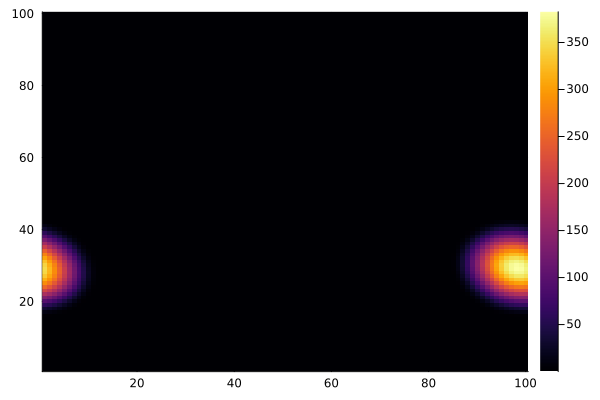

In [237]:
Plots.heatmap(sol_mp[:,:,6,60])

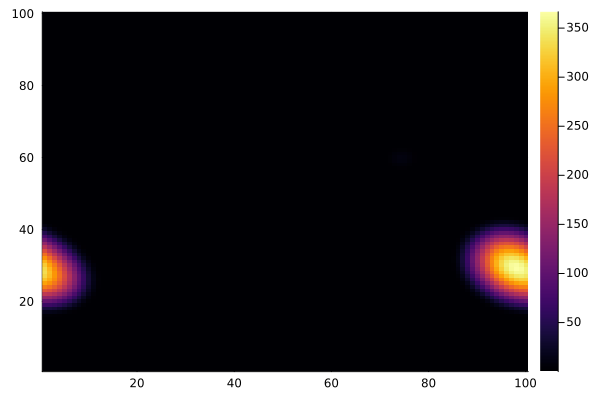

In [228]:
num=40
Plots.heatmap(sol_mp[:,:,5,num]+sol_mp[:,:,6,num]+sol_mp[:,:,4,num])

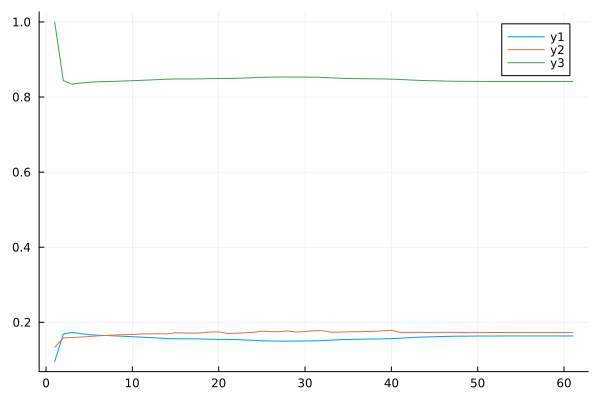

In [239]:
l = length(sol_mp)
tmp1 = mean(sol_mp[:,:,1,1:l]*n, dims=(1,2))
tmp1 = reshape(tmp1, (l))
tmp2 = maximum(sol_mp[:,:,2,1:l]*n, dims=(1,2))
tmp2 = reshape(tmp2, (l))
tmp3 = maximum(sol_mp[:,:,3,1:l], dims=(1,2))
tmp3 = reshape(tmp3, (l))
plot(1:l, [tmp1, tmp2, tmp3])

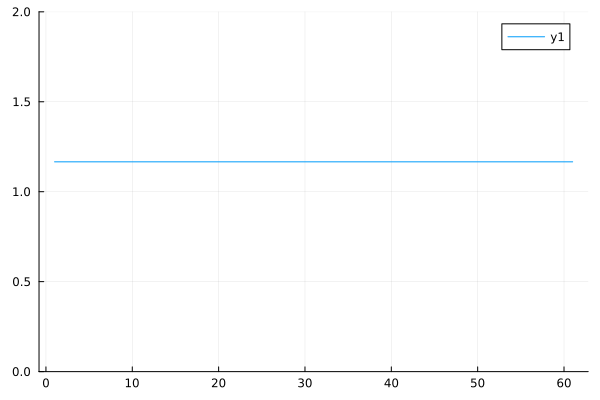

In [230]:
l = length(sol_mp)
tmp3 = mean(sol_mp[:,:,1,1:l]*n, dims=(1,2))
tmp4 = mean(sol_mp[:,:,2,1:l]*n, dims=(1,2))
tmp6 = mean(sol_mp[:,:,6,1:l]*n, dims=(1,2))
tmp5 = mean(sol_mp[:,:,3,1:l], dims=(1,2))
tmp3 = reshape(tmp3+tmp4+tmp5+tmp6, (l))
plot(1:l, [tmp3])
plot!(ylims=(0,2))

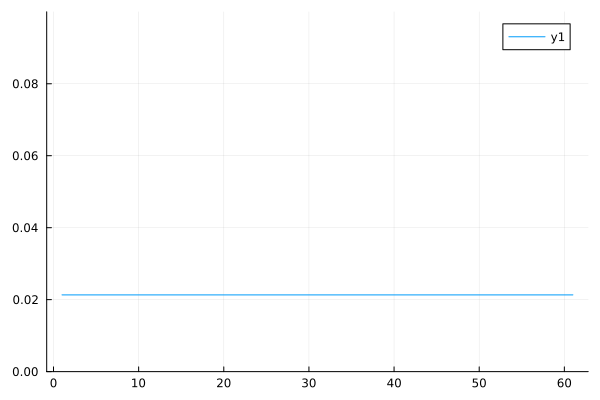

In [225]:
l = length(sol_mp)
tmp3 = mean(sol_mp[:,:,4,1:l], dims=(1,2))
tmp4 = mean(sol_mp[:,:,5,1:l]*n, dims=(1,2))
tmp5 = mean(sol_mp[:,:,6,1:l]*n, dims=(1,2))
tmp2 = reshape(tmp3+tmp4+tmp5, (l))
plot(1:l, [tmp2])
plot!(ylims=(0,.1))

In [177]:
n

60